# Promotional banners simulation

I will fetch the probability per pity count directly from [Paimon.moe](https://paimon.moe)

## 0. Setup

Required dependences

In [1]:
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from random import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st 
from tqdm import tqdm

## 1. Fetch probabilities from Paimon.moe

In [3]:
def get_tally(paimon_id, name):
    tally = requests.get("https://api.paimon.moe/wish?banner=" + str(paimon_id))
    tally = tally.json()

    # Paimon.moe API returns an initial 0, and 10 more zeros at the end
    success_count = np.array(tally["pityCount"]["legendary"][1:91])
    char_wish_count = np.array(tally["countEachPity"])

    # The rate is success / total
    success_rate = success_count / char_wish_count

    # Plot the fetched data, it should look like the graph in the web
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(success_count)
    ax2.plot(success_rate, c="red", ls="--")

    ax1.set_xlabel("Pity")
    ax1.set_ylabel(name + " Count")
    ax2.set_ylabel(name + " Rate")

    return (success_count, success_rate)

### 1.1. Character banner

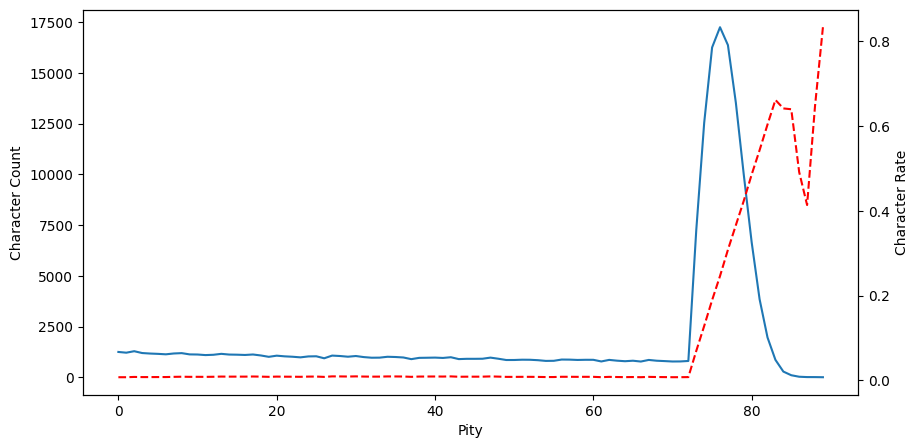

In [4]:
char_success_count, char_success_rate = get_tally("300052", "Character")

### 1.2. Weapon banner

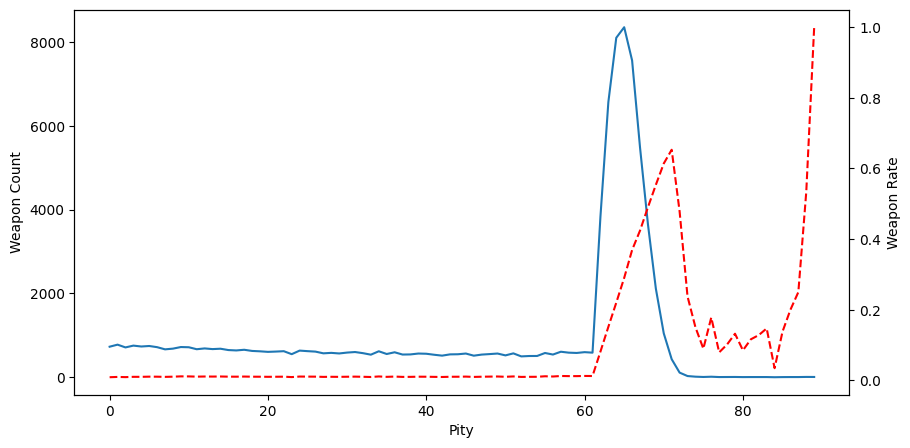

In [5]:
weapon_success_count, weapon_success_rate = get_tally("400053", "Weapon")

## 2. Create the simulator

In [6]:
def chance(P):
  """
  Returns True with probability P
  """
  return random() <= P

In [7]:
class Banner:
  """
  Simulates a banner with the given success rate curve and pity limit
  """
  def __init__(self, success_rate=np.ones(90), max_pity=90):
    self.__pity = 1     # Current pity
    self.__history = {} # How many 5* at each pity
    self.__total = 0    # Total 5*
    self.__success_rates = success_rate
    self.__max_pity = max_pity

  def success_rate(self):
    """
    Returns the success rate at the current pity
    """
    pity = self.__pity
    if pity == self.__max_pity:
      return 1
    return self.__success_rates[pity - 1]

  def wish(self):
    """
    Simulates a wish.
    Returns True if the wish is a success (a 5* obtained), False otherwise.
    """

    # Decide if the wish is a success based on the rate at the current pity
    if chance(self.success_rate()): 
      
      # Increment the history count
      if self.__pity in self.__history:
          self.__history[self.__pity] += 1
      else:
          self.__history[self.__pity] = 1

      # After a success, reset the pity and increment the total count
      self.__pity = 1
      self.__total += 1
      return True
    else:
      self.__pity += 1
      return False

  def xy(self):
    """
    Returns the pity history as a tuple of two arrays:
    - x: pity
    - y: 5* count at that pity
    """
    x = []
    y = []

    for k in range(1, self.__max_pity + 1):
      if k in self.__history:
        x.append(k)
        y.append(self.__history[k])

    return (np.array(x), np.array(y))

  def total(self):
    return self.__total


In [8]:
def CharBanner():
    return Banner(success_rate=char_success_rate, max_pity=90)

def WeaponBanner():
    return Banner(np.ones(90), 80)

### 2.1. Test the simulator behaviour

The following code will simulate several wishes. The resulting chart
should be similar to the one in the website and the section 1.1.

In [9]:
banner = CharBanner()

for i in tqdm(range(10_856_405)):
  banner.wish()

x, y = banner.xy()

  0%|          | 0/10856405 [00:00<?, ?it/s]

100%|██████████| 10856405/10856405 [00:04<00:00, 2308165.08it/s]


,per pity
70,807
71,776
72,841
73,7011
74,12260
75,15737
76,16672
77,15578
78,12866
79,9440


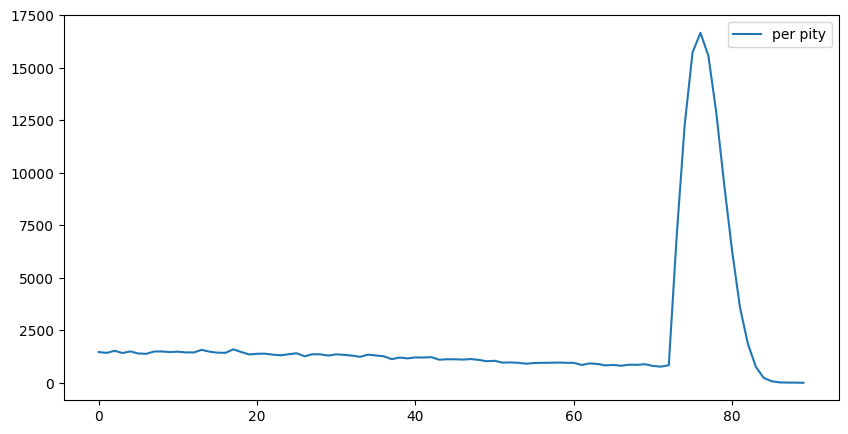

In [10]:
df = pd.DataFrame({"per pity": y})

df.plot(figsize=(10, 5))
df.tail(20)

## 3. Start making questions

### 3.1 ¿how many wishes until N promotionals?

For example: If i want to get two promotionals (likely a C1 promotional character) in the banner,
how many wishes do i need to do?

In [11]:
def wish_until_n_promotionals(n, banner_generator=CharBanner):
  """
  Runs and counts simulated wishes until n promotional 5* are obtained.
  """
  banner = banner_generator()
  count = 0
  wishes = 0
  guaranteed = False
  while count < n:
    wishes += 1
    if not banner.wish(): # if not a 5*, keep wishing
      continue

    if guaranteed or chance(0.5): # count and restart 50/50 if promotional
      count += 1
      guaranteed = False
    else: # if not promotional, guarantee the next one
      guaranteed = True

  return wishes

An initial run only for 2 promotionals:

In [12]:
tries = []
for i in tqdm(range(10_000)):
  tries.append(wish_until_n_promotionals(2))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 17623.00it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x7f92b5911720>,
 'caps': [<matplotlib.lines.Line2D at 0x7f92b59104f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f92b5910070>],
 'medians': [<matplotlib.lines.Line2D at 0x7f92b5912740>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f92b5a1e620>],
 'means': []}

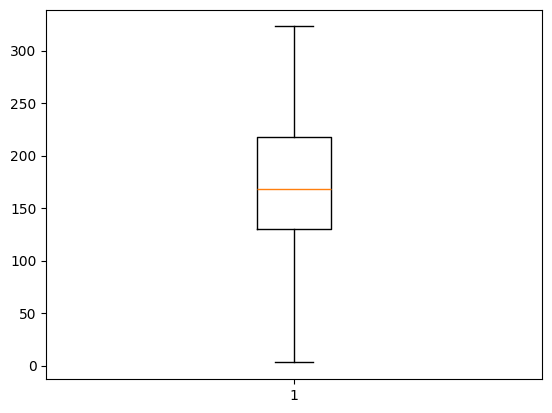

In [13]:
plt.boxplot(tries)

In [14]:
df = pd.DataFrame(tries)
df.describe()

,0
count,10000.000000
mean,172.122500
std,60.663974
min,3.000000
25%,130.000000
50%,168.000000
75%,218.000000
max,323.000000


Now I want a more general analysis: I will run several sims for each number of promotionals desired,
and with the resulting data I will create a chart with the following lines:
- mean wishes
- 95% confidence interval upper and lower bounds 

In [15]:
def sim_n_promotionals(n, banner_generator=CharBanner, runs=10_000):
    data = []

    for _ in range(runs):
        data.append(wish_until_n_promotionals(n, banner_generator))

    return data

In [16]:
rows = {}
for n_prom in tqdm(range(1, 7)):
    data = sim_n_promotionals(n_prom)
    rows[n_prom] = data

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


In [17]:
df = pd.DataFrame(rows)
df.describe()

,1,2,3,4,5,6
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,85.632000,171.579900,256.687000,342.900800,428.559800,514.114700
std,43.044684,60.507346,74.704355,86.868104,95.948868,105.706935
min,1.000000,4.000000,4.000000,46.000000,123.000000,161.000000
25%,61.000000,129.000000,204.000000,282.000000,362.000000,440.000000
50%,79.000000,167.000000,255.000000,342.000000,427.000000,515.000000
75%,115.000000,218.000000,310.000000,401.000000,495.000000,586.000000
max,169.000000,325.000000,484.000000,625.000000,774.000000,902.000000


<Axes: >

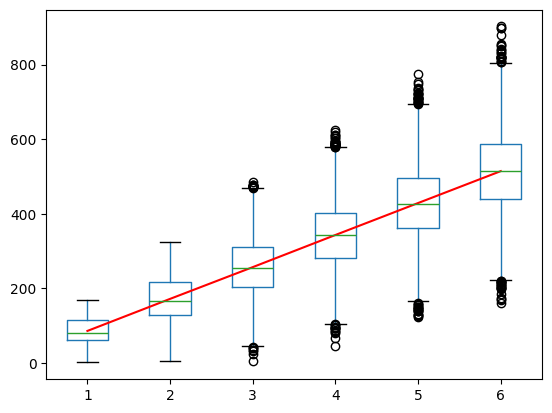

In [18]:
df.boxplot()
df.mean().plot(c="red")